In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame,Series

import matplotlib.pyplot as plt

In [2]:
names = ["userid","time","bank_id","pre_amount_of_bill","pre_repayment","credit_amount",\
         "amount_of_bill_left","least_repayment","consume_amount","amount_of_bill","adjust_amount",\
         "circ_interest","avail_amount","prepare_amount","repayment_state"]

bill_train = pd.read_csv("../../pcredit/train/bill_detail_train.txt",header=None)
bill_test = pd.read_csv("../../pcredit/test/bill_detail_test.txt",header=None)

bill_data = pd.concat([bill_train,bill_test])
bill_data.columns=names
bill_data.head()

,userid,time,bank_id,pre_amount_of_bill,pre_repayment,credit_amount,amount_of_bill_left,least_repayment,consume_amount,amount_of_bill,adjust_amount,circ_interest,avail_amount,prepare_amount,repayment_state
0,3150,5906744363,6,18.626118,18.661937,20.664418,18.905766,17.847133,1,0.0,0.0,0.0,0.0,19.971271,0
1,3150,5906744401,6,18.905766,18.909954,20.664418,19.113305,17.911506,1,0.0,0.0,0.0,0.0,19.971271,0
2,3150,5906744427,6,19.113305,19.150290,20.664418,19.300194,17.977610,1,0.0,0.0,0.0,0.0,19.971271,0
3,3150,5906744515,6,19.300194,19.300280,21.000890,20.303240,18.477177,1,0.0,0.0,0.0,0.0,20.307743,0
4,3150,5906744562,6,20.303240,20.307744,21.000890,20.357134,18.510985,1,0.0,0.0,0.0,0.0,20.307743,0


* 按照列获得数据
* 剔除异常数据,值为 0 
* 按照 userid 和 bank_id 进行 groupby
* 对每一个 userid 和 bank_id 构建模型
* 获得 ARIMA 的阶数
* 构造 userid (q,p) 的 DataFrame

In [3]:
pre_amount_of_bill = bill_data[['userid','bank_id','pre_amount_of_bill']]
pre_amount_of_bill = pre_amount_of_bill[pre_amount_of_bill['pre_amount_of_bill']!=0]
pre_amount_of_bill.head()

,userid,bank_id,pre_amount_of_bill
0,3150,6,18.626118
1,3150,6,18.905766
2,3150,6,19.113305
3,3150,6,19.300194
4,3150,6,20.303240


[在 DataFrame 中添加一行](http://stackoverflow.com/questions/10715965/add-one-row-in-a-pandas-dataframe)

In [99]:
df = pd.DataFrame(columns=('userid','p'))
df.loc[0] = [1,(2,3)]
df.loc[1] = [4,(3,5)]
df.head()

,userid,p
0,1.0,"(2, 3)"
1,4.0,"(3, 5)"


In [4]:
"""
    data2Diff = temp.diff()  # 差分
    temp = np.array(data2Diff)[1:]
    print temp
    t = sm.tsa.stattools.adfuller(temp,1)  # ADF检验
    print t[1]
    print sm.tsa.arma_order_select_ic(temp,max_ar=6,max_ma=4,ic='aic')['aic_min_order']  # AIC
"""
import warnings
import statsmodels.api as sm
warnings.filterwarnings('ignore')
pre_amount_of_bill_g = pre_amount_of_bill.groupby(['userid','bank_id'])
df = pd.DataFrame(columns=('userid','p'))
i = 0;
for k,group in pre_amount_of_bill_g:
    userid = k[0]
    if i > 10:
           break
    if len(group) >4:
        data2Diff = group['pre_amount_of_bill'].diff()
        temp = np.array(data2Diff)[1:]
        p = sm.tsa.arma_order_select_ic(temp,max_ar=6,max_ma=6,ic='aic')['aic_min_order']
        pp = "{}{}".format(p[0],p[1])
        df.loc[i] = [userid,pp]
        i += 1
df.to_csv("../../pcredit/train/pre_amount_of_bill.csv",index=None)
df.head()

In [5]:
df['count'] = 1
df.head()

,userid,p,count
0,2.0,21,1
1,2.0,41,1
2,4.0,01,1
3,6.0,01,1
4,6.0,01,1


In [17]:
#  每个 userid 的参数可能有多个相同的阶数
dd = pd.pivot_table(df,index=['userid','p'],values=['count'],aggfunc=sum)
dd.head()

count
userid p        
2.0    21      1
       41      1
4.0    01      1
6.0    01      3
7.0    01      2

In [18]:
dd = dd.unstack()
dd.head()

count                    
p         01   02   21   41   50
userid                          
2.0      NaN  NaN  1.0  1.0  NaN
4.0      1.0  NaN  NaN  NaN  NaN
6.0      3.0  NaN  NaN  NaN  NaN
7.0      2.0  1.0  NaN  NaN  NaN
9.0      1.0  NaN  NaN  NaN  1.0

In [19]:
n = dd.shape[1]
dd.columns = [ 'pre_amount_of_bill##{}'.format(i) for i in range(n)]
dd = dd.fillna(0)
dd.index.astype(int)
dd.head()

,pre_amount_of_bill##0,pre_amount_of_bill##1,pre_amount_of_bill##2,pre_amount_of_bill##3,pre_amount_of_bill##4
userid,,,,,
2.0,0.0,0.0,1.0,1.0,0.0
4.0,1.0,0.0,0.0,0.0,0.0
6.0,3.0,0.0,0.0,0.0,0.0
7.0,2.0,1.0,0.0,0.0,0.0
9.0,1.0,0.0,0.0,0.0,1.0


In [78]:
bill_data[bill_data['userid']==3]

,userid,time,bank_id,pre_amount_of_bill,pre_repayment,credit_amount,amount_of_bill_left,least_repayment,consume_amount,amount_of_bill,adjust_amount,circ_interest,avail_amount,prepare_amount,repayment_state
20587,3,0,2,18.371030,19.495329,18.361833,18.325511,16.022895,3,19.480767,0.0,0.0,0.0,0.0,0
20588,3,0,2,18.362512,17.665019,18.361833,18.371030,16.068406,1,17.682056,0.0,0.0,0.0,0.0,0


In [9]:
bill_detail_bank =bill_data.groupby(['userid','bank_id'])

In [10]:
i = 0
for k,d in bill_detail_bank:
    print k
    print d
    if i >=5:
        break
    i = i+1

(2, 4)
       userid        time  bank_id  pre_amount_of_bill  pre_repayment  \
12291       2           0        4           17.389606      17.389606   
12292       2  5904923847        4           17.389606      17.389606   
12293       2  5907300387        4           16.656269      17.402921   
12295       2  5909977167        4           19.393161      19.446400   
12298       2  5912593347        4            0.000000       0.000000   
12301       2  5915295627        4            0.000000       0.000000   
12304       2  5917953567        4            0.000000       0.000000   
12310       2  5925655887        4           18.647124      18.988680   
12312       2  5928420687        4           19.115077      19.509829   

       credit_amount  amount_of_bill_left  least_repayment  consume_amount  \
12291      19.460445            16.656269        15.366101               1   
12292      19.460445            16.656269        15.366101               1   
12293      19.460445        

In [35]:
from statsmodels.tsa.stattools import acf,pacf
import statsmodels.api as sm

cols = ['pre_amount_of_bill','pre_repayment','credit_amount','amount_of_bill_left','least_repayment','prepare_amount']

i = 0
for k,d in bill_detail_bank:
    if i >=1:
        break
    i = i+1
    n = len(d[col])
    Acf,q,p = acf(d['credit_amount'],nlags=n,qstat=True)
    #for col in cols:
    '''
        nn = (0,10)
        sm.graphics.tsa.plot_acf(d[col])
        tModel = sm.tsa.ARMA(d[col],nn).fit()
        delta = tModel.fittedvalues - d[col]
        score = 1 - delta.var()/d[col].var()
        print col,score
    '''
    #pre_amount_of_billACF = pd.DataFrame(acf(d['pre_amount_of_bill']))
    #pre_amount_of_billACF.plot(title='pre_amount_of_billACF',kind='bar')
    #pre_amount_of_billPACF = pd.DataFrame(pacf(d['pre_amount_of_bill']))
    #pre_amount_of_billPACF.plot(title='pre_amount_of_billPACF',kind='bar')
#plt.show()
print Acf
print q
print p

[ 1.          0.38740934 -0.15008076 -0.5043689  -0.33377369 -0.07048671
  0.0047848   0.10975464  0.05676128]
[ 1.85731423  2.17587127  6.37327306  8.57908958  8.70205689  8.70281241
  9.29909343  9.61805583]
[ 0.1729351   0.33691128  0.09479654  0.07252582  0.12155469  0.19099438
  0.23188967  0.29286278]


[68.68379579045968, 69.726271776625, 68.47997272196031, nan, 69.70024963100403]


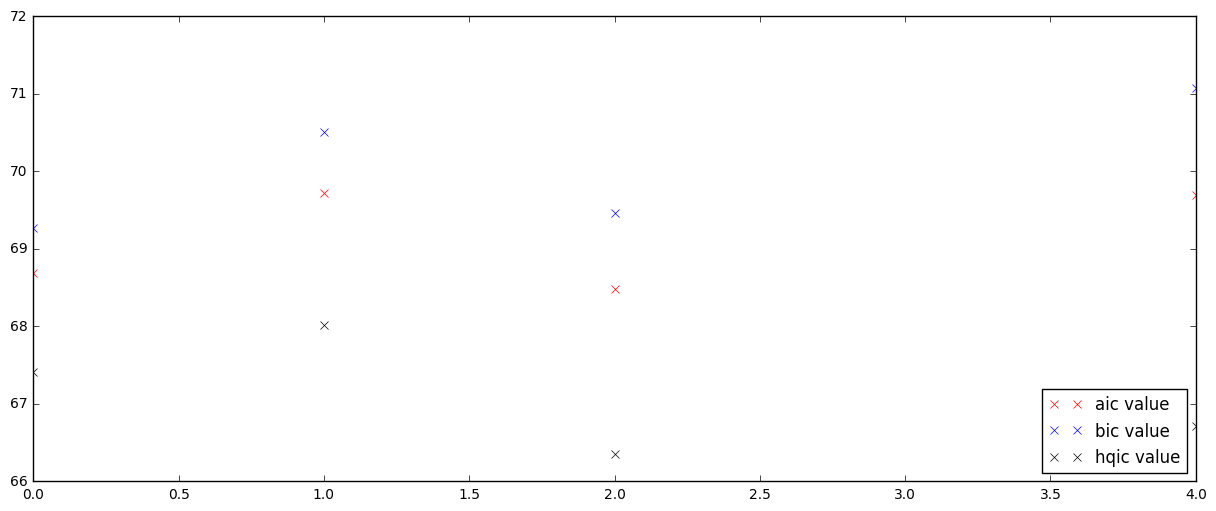

In [53]:
aicList = []
bicList = []
hqicList = []
for i in range(1,6):  #从1阶开始算
    order = (i,0)  # 这里使用了ARMA模型，order 代表了模型的(p,q)值，我们令q始终为0，就只考虑了AR情况。
    tempModel = sm.tsa.ARMA(temp,order).fit()
    aicList.append(tempModel.aic)
    bicList.append(tempModel.bic)
    hqicList.append(tempModel.hqic)
print aicList
plt.figure(figsize=(15,6))
plt.plot(aicList,'rx',label='aic value')
plt.plot(bicList,'bx',label='bic value')
plt.plot(hqicList,'kx',label='hqic value')
plt.legend(loc=4)
plt.show()

In [70]:
i = 0
for k,d in bill_detail_bank:
    if i >=1:
        break
    i = i+1
    temp = d['least_repayment'] # 载入收益率序列
    print temp
    data2Diff = temp.diff()  # 差分
    temp = np.array(data2Diff)[1:]
    print temp
    t = sm.tsa.stattools.adfuller(temp,1)  # ADF检验
    print t[1]
    print sm.tsa.arma_order_select_ic(temp,max_ar=6,max_ma=4,ic='aic')['aic_min_order']  # AIC

12291    15.366101
12292    15.366101
12293    17.092432
12295    17.123958
12298    17.206650
12301    17.237903
12304    15.872918
12310    16.815370
12312    16.938874
Name: least_repayment, dtype: float64
[ 0.        1.726331  0.031526  0.082692  0.031253 -1.364985  0.942452
  0.123504]
0.03816243155


/home/hadoop/env2.7/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/hadoop/env2.7/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/hadoop/env2.7/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/hadoop/env2.7/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/hadoop/env2.7/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood opti

(4, 0)


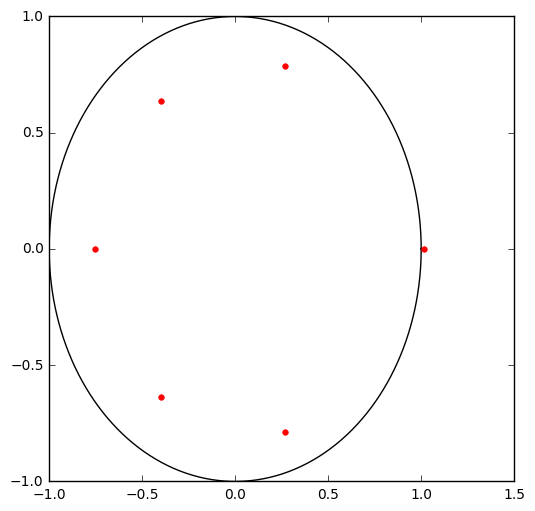

In [40]:
pi,sin,cos = np.pi,np.sin,np.cos
r1 = 1
theta = np.linspace(0,2*pi,360)
x1 = r1*cos(theta)
y1 = r1*sin(theta)
plt.figure(figsize=(6,6))
plt.plot(x1,y1,'k')  # 画单位圆
roots = 1/results_AR.roots  # 注意，这里results_AR.roots 是计算的特征方程的解，特征根应该取倒数
for i in range(len(roots)):
    plt.plot(roots[i].real,roots[i].imag,'.r',markersize=8)  #画特征根
plt.show()

In [56]:
temp = d['pre_amount_of_bill']
print temp
t = sm.tsa.stattools.adfuller(temp)  # ADF检验
print 'P-value:',t[1]

12296    20.210676
12299    19.951884
12302    19.972470
12305    19.563002
Name: pre_amount_of_bill, dtype: float64


ValueError: maxlag should be < nobs